
# <span style="color:rgb(213,80,0)">Segmenting an image of Greek coins into regions</span>

This demo closely follows a scikit-learn image segmentation example available at [https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_segmentation.html](https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_segmentation.html)


That example uses spectral clustering to identify connected pixel regions of similar grayscale in an image. [Spectral clustering](https://en.wikipedia.org/wiki/Spectral_clustering) is well suited for image segmentation tasks as it naturally works with graph Laplacians that can encode neighborhood information about nodes (in this case, the nodes are the pixels of an image). In such a way, the method favors clustering nearby pixels together, tending to produce connected 2D regions in an image.


CLASSIX is primarily a *distance-based* clustering method, and so it is natural to encode affinity information of pixels as additional features of the data points. More precisely, we can represent each grayscale pixel as a 3D point of the form [c,scl*x,scl*y], where <samp>c</samp> is the grayscale value, and <samp>x,y</samp> are the pixel coordinates. The scaling parameter <samp>scl</samp> is used to control the relative weighting between colour and position of a pixel.


In this example we make use of [MATLAB's Python interface](https://uk.mathworks.com/help/matlab/call-python-libraries.html) to load the Greek coins image and preprocess it (smooth, downsample) exactly as in the scikit-learn image segmentation example.



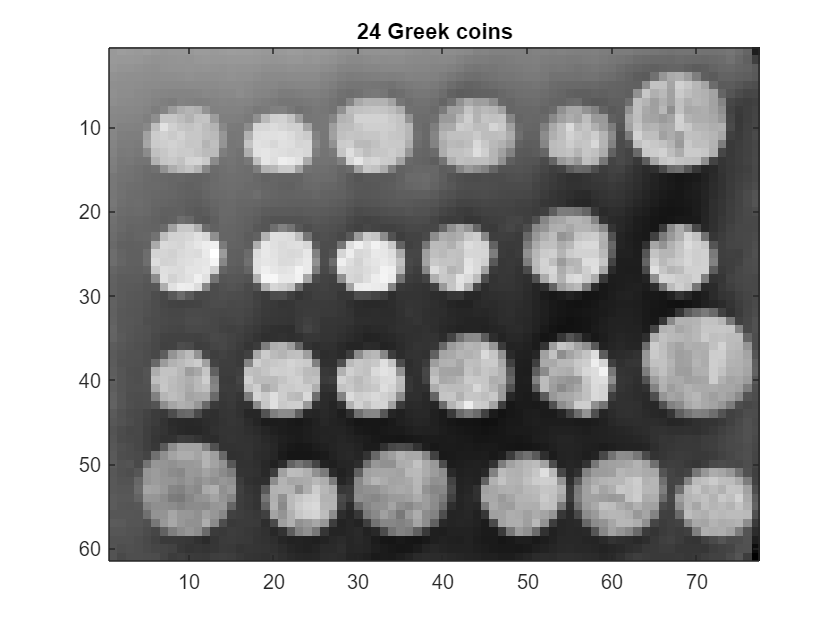

In [1]:
clear all
addpath ..

% get data
pyrun("from skimage.data import coins")
pyrun("from scipy.ndimage import gaussian_filter")
pyrun("from skimage.transform import rescale")

pyrun("orig_coins = coins()")
% Resize it to 20% of the original size to speed up the processing
% Applying a Gaussian filter for smoothing prior to down-scaling
% reduces aliasing artifacts.
pyrun("smoothened_coins = gaussian_filter(orig_coins, sigma=2)")
coins = pyrun("coins = rescale(smoothened_coins, 0.2, mode='reflect', anti_aliasing=False)","coins");
coins = double(coins);

% plot
imagesc(coins), colormap gray, title('24 Greek coins')

## Running CLASSIX

We now run CLASSIX. The parameters required some fine tuning, but CLASSIX runs fast enough for this to be done interactively.


In [2]:
[ny,nx] = size(coins);
[X,Y] = meshgrid(1:nx,1:ny);
scl = 0.08;  % locality weighting
data = [ coins(:), scl*X(:), scl*Y(:) ];
tic
[labels,explain,out] = classix(data,0.03,20);
fprintf('Runtime in seconds: %f\nNumber of clusters: %d', toc, length(unique(labels)))

Runtime in seconds: 0.404812
Number of clusters: 25


This took just about 0.4 seconds. Note that 25 clusters were computed. These correspond to the 24 coins plus the image background.


Calling CLASSIX's <samp>explain</samp> method leads to fascinating output: it essentially regenerates the original image without "knowing" that the provided 3D data matrix corresponded to an image!


CLASSIX clustered 4697 data points with 3 features.
The radius parameter was set to 0.03 and MinPts was set to 20.
As the provided data was auto-scaled by a factor of 1/2.19,
points within a radius R=0.03*2.19=0.07 were grouped together.
In total, 140910 distances were computed (30.0 per data point).
This resulted in 4697 groups, each with a unique group center.
These 4697 groups were subsequently merged into 25 clusters.
In order to explain the clustering of individual data points,
use explain(ind1) or explain(ind1,ind2) with indices of points.


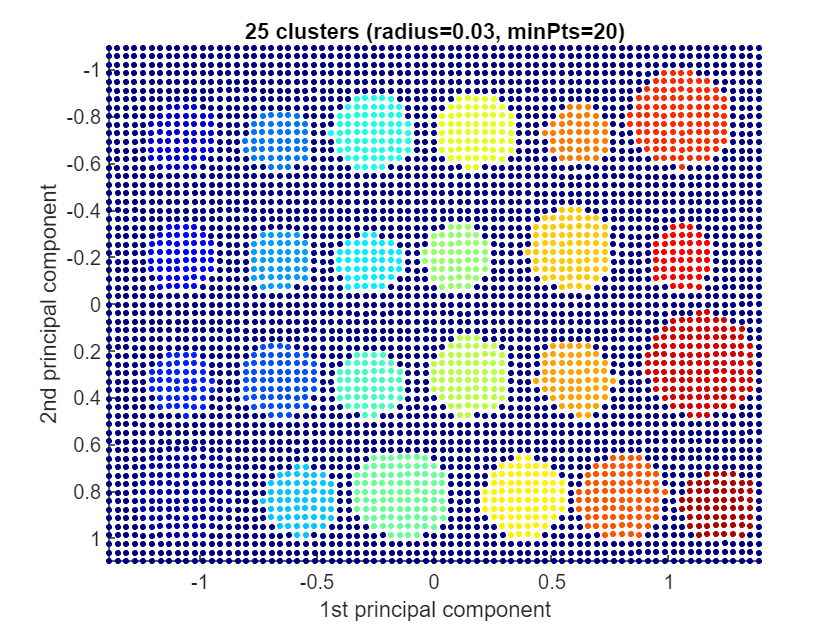

In [3]:
explain(); axis ij

## Explaining the clustering

CLASSIX is an *explainable* clustering method which provides justifications for its computations. Let's find out why two data points (pixels) have been assigned to the same class (=coin):


Data point 4000 is in group 3979, which was merged into cluster #24.
Data point 4313 is in group 4299, which was merged into cluster #24.
A path of overlapping groups with step size <= 1.5*R = 0.10 is:
 3979 -> 3984 -> 3983 -> 3982 -> 3985 -> 3987 -> 3988 -> 4056 -> 4054 -> 4118 -> 4172 -> 4179 -> 4236 -> 4299
(Note that with data having more than 2 features, the two
 group circles in the plot may appear bigger than they are.)


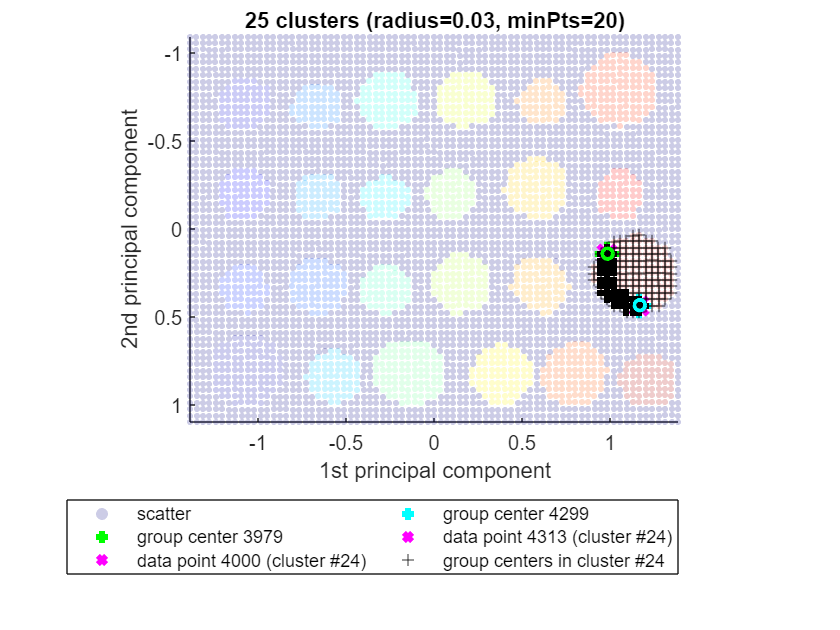

In [4]:
explain(4000,4313); axis ij


CLASSIX explains that there is a path of data points within cluster #24 that connects the two data points with indices 4000 and 4313, and the step sizes on this path are small (bounded by the radius parameter we have chosen when calling CLASSIX).

## Comparison with CLASSIX.PY and other methods

The repository of the Python implementation ([CLASSIX.PY](https://github.com/nla-group/classix)) contains a very similar demo including comparisons to spectral clustering: [https://github.com/nla-group/classix/blob/master/demos/Segmenting_greek_coins.ipynb](https://github.com/nla-group/classix/blob/master/demos/Segmenting_greek_coins.ipynb)


 When run on the same laptop

-  [spectral clustering](https://github.com/nla-group/classix/blob/master/demos/Segmenting_greek_coins.ipynb) required about 3.17 seconds
-  [CLASSIX.PY](https://github.com/nla-group/classix) required about 0.61 seconds
-  [CLASSIX.M](https://github.com/nla-group/classix-matlab) (this example) required about 0.40 seconds

to segment the Greek coin image to similar quality.


It is a common observation that CLASSIX's MATLAB implementation is slightly faster than Python. In Python, using sklearn's <samp>spectral_clustering</samp> method with the <samp>cluster_qr</samp> option (the fastest we have tried), CLASSIX.PY is about five times faster than spectral clustering on this example.

